## Background : 

The project relates to Object Recognition.  The data contains features extracted from the silhouette of vehicles in different angles. 3D objects within a 2D image by application of an ensemble of shape feature extractors to the 2D silhouettes of the objects. Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. 


## Project Objective :

The purpose is to classify a given silhouette as one of three types of vehicle, namely, bus, van or car, using a set of features extracted from the silhouette,viewed from constrained elevation but all angles of rotation.  The project requires that dimensionality reduction techniques – specifically, PCA be applied and a model be trained using principle components.

In [1]:
# Import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import math
import scipy.stats as stats
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold   
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.decomposition import PCA

In [2]:
# Load the data
df = pd.read_csv('vehicle-1.csv')

### Raw Data :

The features were extracted from the silhouettes by the HIPS (Hierarchical Image Processing System) extension BINATTS, which extracts a combination of scale independent features utilising both classical moments based measures such as scaled variance, skewness and kurtosis about the major/minor axes and heuristic measures such as hollows, circularity, rectangularity and compactness.

Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.

The images were acquired by a camera looking downwards at the model vehicle from a fixed angle of elevation (34.2 degrees to the horizontal). The vehicles were placed on a diffuse backlit surface (lightbox). The vehicles were painted matte black to minimise highlights. The images were captured using a CRS4000 framestore connected to a vax 750. All images were captured with a spatial resolution of 128x128 pixels quantised to 64 greylevels. These images were thresholded to produce binary vehicle silhouettes, negated (to comply with the processing requirements of BINATTS) and thereafter subjected to shrink-expand-expand-shrink HIPS modules to remove "salt and pepper" image noise.

The vehicles were rotated and their angle of orientation was measured using a radial graticule beneath the vehicle. 0 and 180 degrees corresponded to "head on" and "rear" views respectively while 90 and 270 corresponded to profiles in opposite directions. Two sets of 60 images, each set covering a full 360 degree rotation, were captured for each vehicle. The vehicle was rotated by a fixed angle between images. These datasets are known as e2 and e3 respectively.

A further two sets of images, e4 and e5, were captured with the camera at elevations of 37.5 degs and 30.8 degs respectively. These sets also contain 60 images per vehicle apart from e4.van which contains only 46 owing to the difficulty of containing the van in the image at some orientations.

The data is organised into several columns as follows:-
    
    1. compactness -  The values of this feature in this dataset range between 73 and 119 units.
    
    2. circularity - Values range from 33 to 59 units with five blanks.  
    
    3. distance_circularity  - Values range between 40 and 112 units with blanks as well.  In fact, in one row both circularity                     and distance circularity have missing values. 
    
    4. radius_ratio - Values between 104 to 333 units with blanks. 
    
    5. pr.axis_aspect_ratio  - The principal axis aspect ratio has values between 47 to 138 with two blanks.
    
    6. max.length_aspect_ratio  - Varies between two and 55 unnits with no blanks.
    
    7. scatter_ratio - Varies between 112 and 265 with one missing value.
    
    8. elongatedness   - Varies between 26 and 61 with one blank.
    9. pr.axis_rectangularity -  Varies between 17 to 29 with three blanks.
    10. max.length_rectangularity - Varies between 118 to 128.
    
    11. scaled_variance   - Values vary between 136 to 320 with blanks.
    12. scaled_variance.1   - Values vary between 184 to 1018 with blanks.
    
    13. scaled_radius_of_gyration  - 109 to 268 with missing values.
    14. scaled_radius_of_gyration.1 - 59 to 135 with missing values.
    
    15. skewness_about   - 0 to 22 with blanks.
    16. skewness_about.1 - 0 to 41 with blanks.
    17. skewness_about.2 - 176 to 206 with blanks.
    
    18. hollows_ratio  - Varires between 181 to 211 with no missing values.
    
    19. class  - Class of the vehicle.  This is the target variable. Non-numeric with three categories, bus, car , van.

  Details of the parameters are available at https://archive.ics.uci.edu/ml/datasets/Statlog+(Vehicle+Silhouettes) 
  Accessed on 30 Oct 2020.
  
  It can be discerned that there are 18 independent features (all numeric) and one dependent feature (class).

In [3]:
df.sample(5)

compactness  circularity  distance_circularity  radius_ratio  \
687          106         57.0                 107.0         235.0   
18           104         54.0                 100.0         186.0   
179           89         44.0                  70.0         137.0   
97            86         43.0                  68.0         152.0   
828           89         42.0                  66.0         125.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
687                  67.0                        6          262.0   
18                   61.0                       10          216.0   
179                  58.0                        6          136.0   
97                   62.0                        7          150.0   
828                  53.0                        7          131.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
687           26.0                    28.0                        171   
18            31.0                    24.0                        173   
179           49.0                    18.0                        146   
97            44.0                    19.0                        142   
828           51.0                    18.0                        144   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
687            285.0              987.0                      260.0   
18             225.0              686.0                      220.0   
179            168.0              273.0                      166.0   
97             179.0              337.0                      164.0   
828            162.0              254.0                      162.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
687                         86.0             9.0              31.0   
18                          74.0             5.0              11.0   
179                         78.0            10.0               3.0   
97                          75.0             4.0               9.0   
828                         73.0            10.0              17.0   

     skewness_about.2  hollows_ratio class  
687             180.0            184   bus  
18              185.0            195   car  
179             186.0            187   van  
97              188.0            192   bus  
828             188.0            191   van

## Data Pre-processing

In [4]:
df.info()  # 846 entries, maximum in 19 columns.  The columns with missing values can be made out as well.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

In [5]:
df.describe().T

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  841.0   44.828775    6.152172   33.0   40.00   
distance_circularity         842.0   82.110451   15.778292   40.0   70.00   
radius_ratio                 840.0  168.888095   33.520198  104.0  141.00   
pr.axis_aspect_ratio         844.0   61.678910    7.891463   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                845.0  168.901775   33.214848  112.0  147.00   
elongatedness                845.0   40.933728    7.816186   26.0   33.00   
pr.axis_rectangularity       843.0   20.582444    2.592933   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              843.0  188.631079   31.411004  130.0  167.00   
scaled_variance.1            844.0  439.494076  176.666903  184.0  318.00   
scaled_radius_of_gyration    844.0  174.709716   32.584808  109.0  149.00   
scaled_radius_of_gyration.1  842.0   72.447743    7.486190   59.0   67.00   
skewness_about               840.0    6.364286    4.920649    0.0    2.00   
skewness_about.1             845.0   12.602367    8.936081    0.0    5.00   
skewness_about.2             845.0  188.919527    6.155809  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   

                               50%    75%     max  
compactness                   93.0  100.0   119.0  
circularity                   44.0   49.0    59.0  
distance_circularity          80.0   98.0   112.0  
radius_ratio                 167.0  195.0   333.0  
pr.axis_aspect_ratio          61.0   65.0   138.0  
max.length_aspect_ratio        8.0   10.0    55.0  
scatter_ratio                157.0  198.0   265.0  
elongatedness                 43.0   46.0    61.0  
pr.axis_rectangularity        20.0   23.0    29.0  
max.length_rectangularity    146.0  159.0   188.0  
scaled_variance              179.0  217.0   320.0  
scaled_variance.1            363.5  587.0  1018.0  
scaled_radius_of_gyration    173.5  198.0   268.0  
scaled_radius_of_gyration.1   71.5   75.0   135.0  
skewness_about                 6.0    9.0    22.0  
skewness_about.1              11.0   19.0    41.0  
skewness_about.2             188.0  193.0   206.0  
hollows_ratio                197.0  201.0   211.0

In [6]:
sum(df.duplicated()) # no duplicates

0

In [7]:
skew = df.skew()
kurt = df.kurt()
pd.concat([skew.rename('skewness'), kurt.rename('kurtosis')],axis=1)

skewness   kurtosis
compactness                  0.381271  -0.535275
circularity                  0.261809  -0.922925
distance_circularity         0.106585  -0.977287
radius_ratio                 0.394978   0.304921
pr.axis_aspect_ratio         3.830362  29.889135
max.length_aspect_ratio      6.778394  58.375455
scatter_ratio                0.607271  -0.616570
elongatedness                0.047847  -0.866601
pr.axis_rectangularity       0.770889  -0.390508
max.length_rectangularity    0.256359  -0.770098
scaled_variance              0.651598   0.120071
scaled_variance.1            0.842034  -0.203819
scaled_radius_of_gyration    0.279317  -0.496336
scaled_radius_of_gyration.1  2.083496  11.455759
skewness_about               0.776519   0.094077
skewness_about.1             0.688017  -0.144728
skewness_about.2             0.249321  -0.588758
hollows_ratio               -0.226341  -0.813435

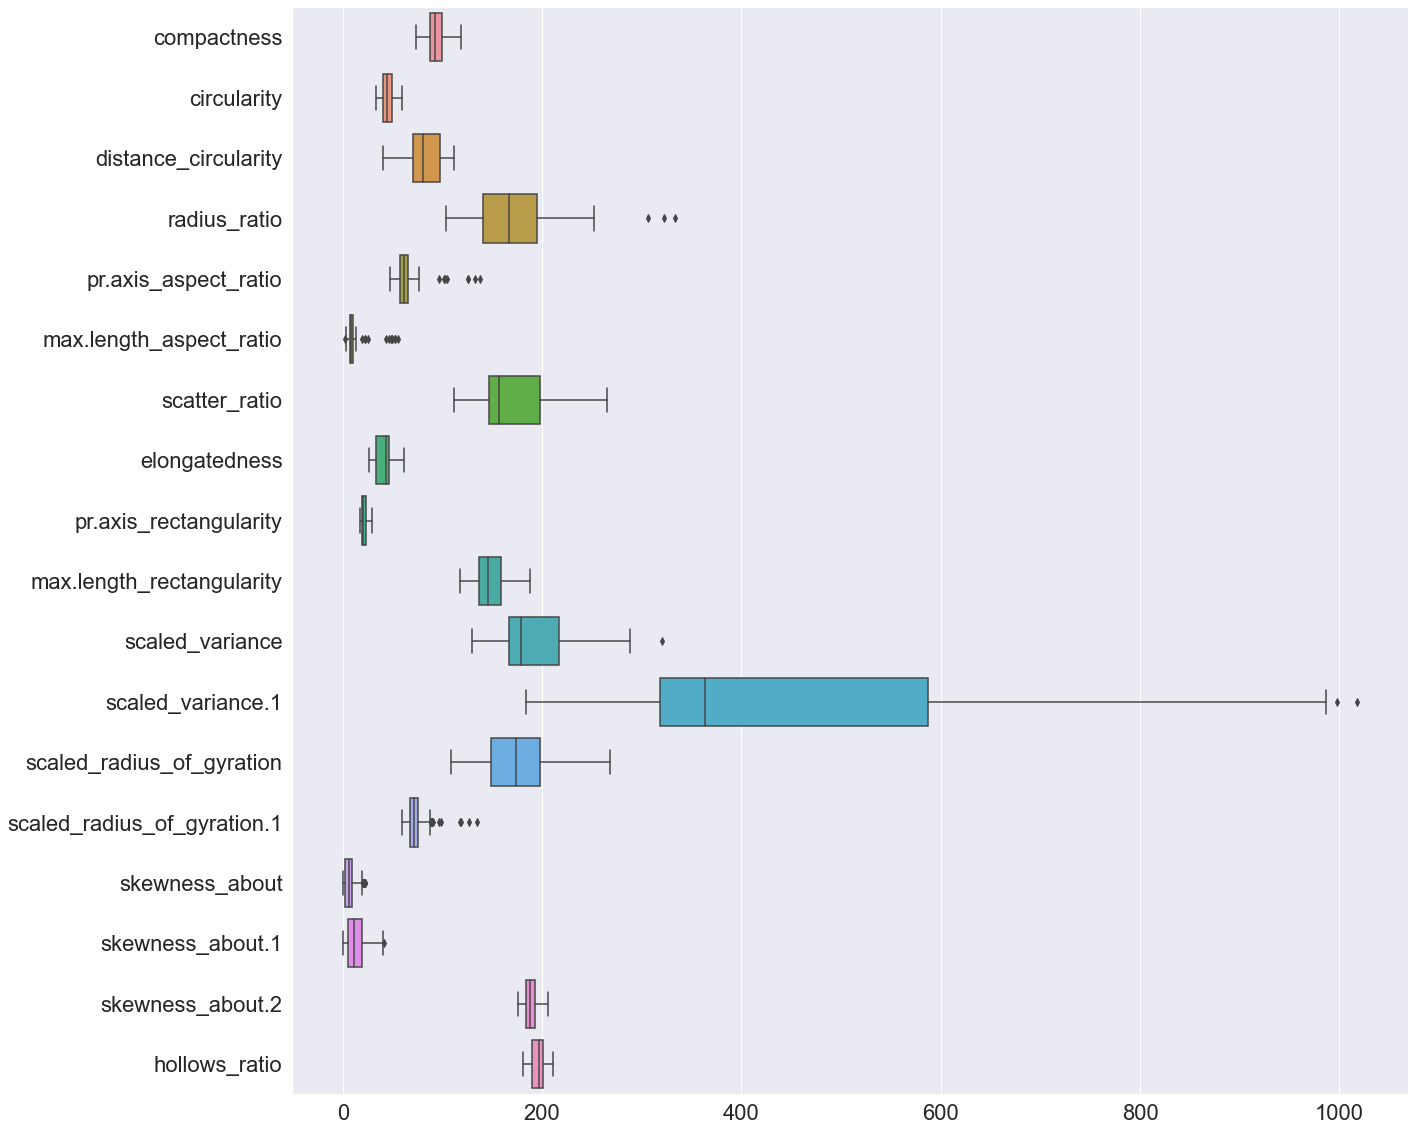

In [8]:
sns.set(style='white')
sns.set(style='whitegrid',color_codes=True)
sns.set(palette='coolwarm')
sns.set(font_scale=2)
plt.figure(figsize=(20,20))
sns.boxplot(data = df,orient="h")
plt.show()

As a preliminary assessment, most of the features are symmetrically distributed except the following features:-

#### Moderately Right Skewed :-

scatter_ratio,    
scaled_variance,    
scaled_variance.1,    
skewness_about,    
skewness_about.1,   
pr.axis_rectangularity. 

#### Highly Right Skewed:-

scaled_radius_of-gyration.1,    
pr.axis_aspect_ratio,    
max.length_aspect_ratio. 

#### The presence of outliers in the highly skewed variables is also noticeable.

Outliers are present in columns including radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scaled_variance, scaled_variance.1, scaled_radius_of-gyration.1, skewness_about, skewness_about.1.

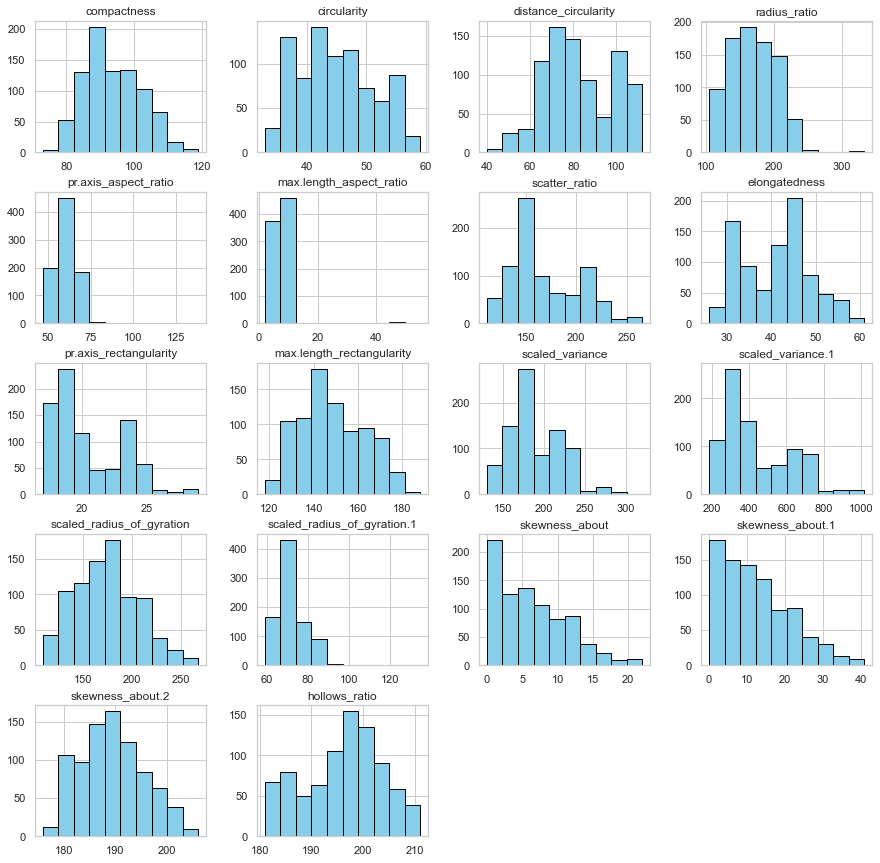

In [9]:
plt.rc('font',size=14)
sns.set(style='white')
sns.set(style='whitegrid',color_codes=True)
df.hist(figsize=(15,15),color = "skyblue",edgecolor='black');

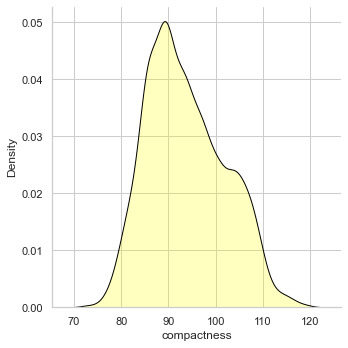

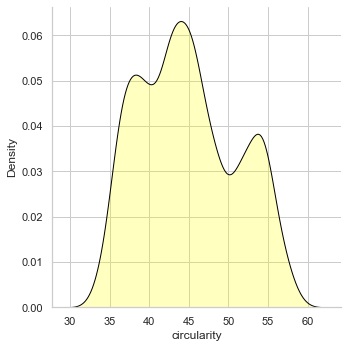

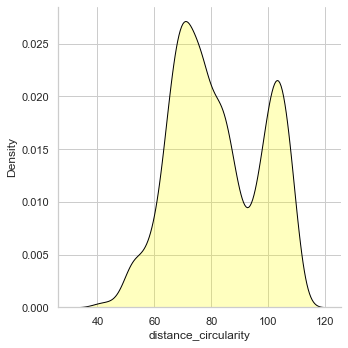

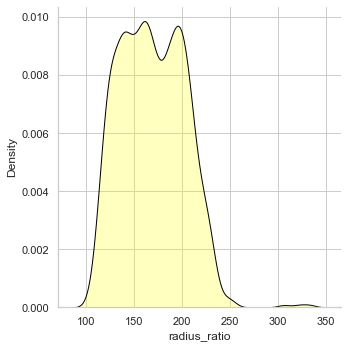

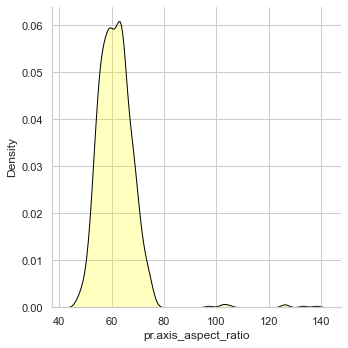

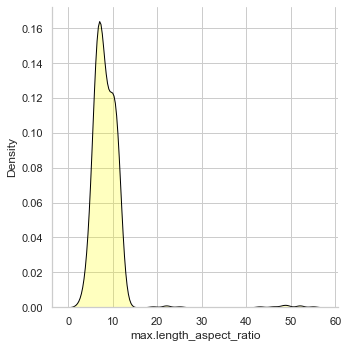

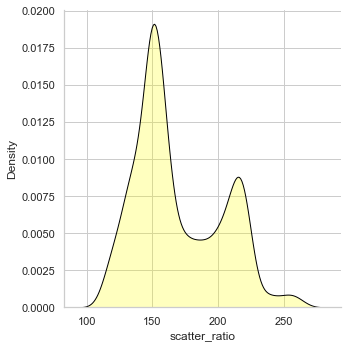

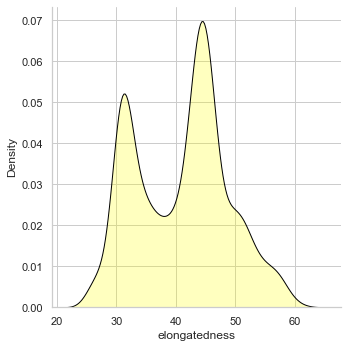

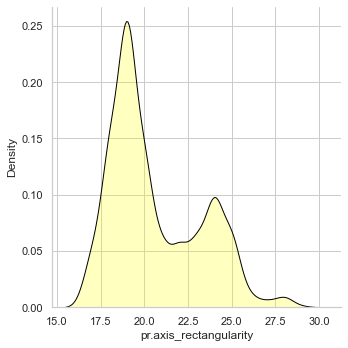

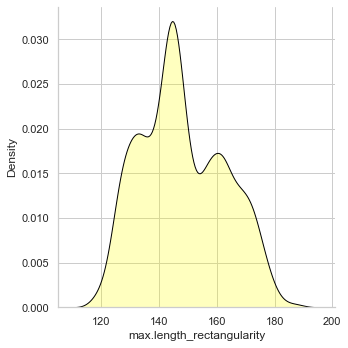

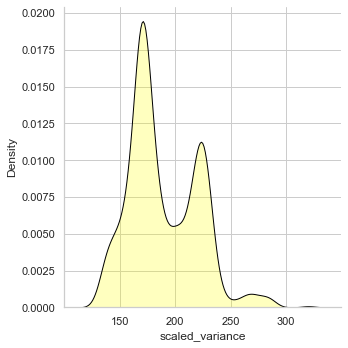

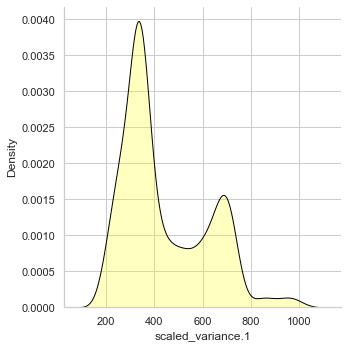

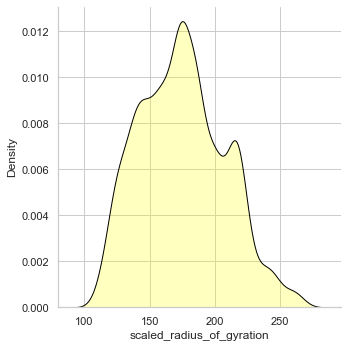

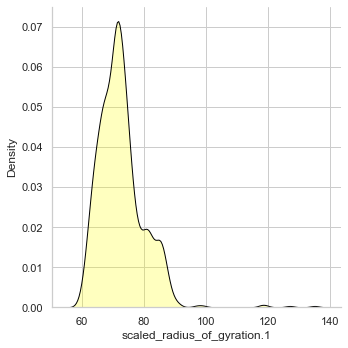

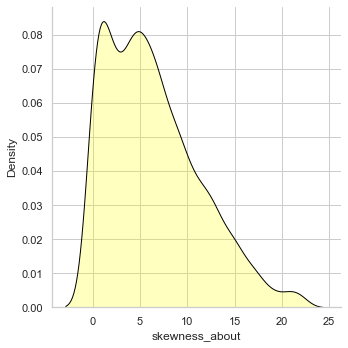

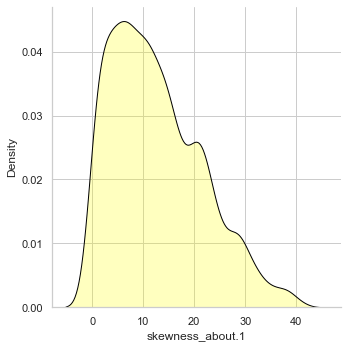

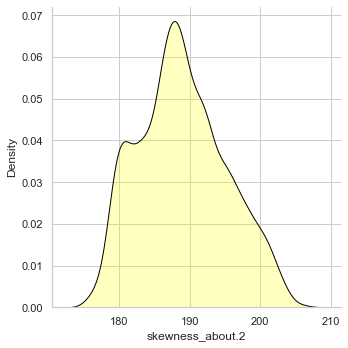

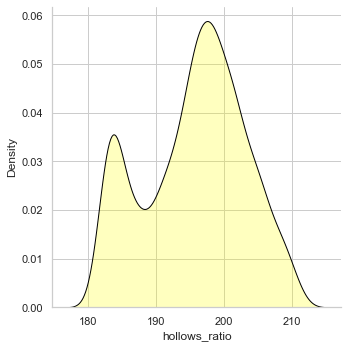

In [10]:
sns.displot(df["compactness"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["circularity"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["distance_circularity"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["radius_ratio"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["pr.axis_aspect_ratio"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["max.length_aspect_ratio"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["scatter_ratio"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["elongatedness"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["pr.axis_rectangularity"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["max.length_rectangularity"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["scaled_variance"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["scaled_variance.1"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["scaled_radius_of_gyration"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["scaled_radius_of_gyration.1"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["skewness_about"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["skewness_about.1"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["skewness_about.2"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');
sns.displot(df["hollows_ratio"],  kind="kde", bw_adjust=.75, fill=True, color='yellow', edgecolor='black');

Our observations on data skewness are validated by these visual representations.

In [11]:
print('Class: \n',df['class'].unique())

Class: 
 ['van' 'car' 'bus']


In [12]:
df['class'].value_counts()

car    429
bus    218
van    199
Name: class, dtype: int64

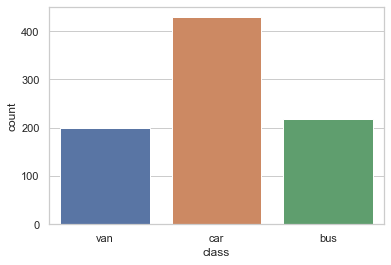

In [13]:
sns.countplot(df['class']);

### Handling Missing Values

In [14]:
df.isnull().sum()  # Verifying missing values in various features.

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

In [15]:
df = df.replace(' ', np.nan)  # Replacing missing variables with median values.
for i in df.columns[:17]: # hollows_ratio has no missing values.
    median_value = df[i].median()
    df[i] = df[i].fillna(median_value)

#### Median values are preferred as many features are skewed.

In [16]:
df.isnull().sum() # Crosscheck to ensure that there are no missing variables any more.

compactness                    0
circularity                    0
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
class                          0
dtype: int64

In [17]:
df.info() # 846 entries in 19 columns with no blanks.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  846 non-null    float64
 2   distance_circularity         846 non-null    float64
 3   radius_ratio                 846 non-null    float64
 4   pr.axis_aspect_ratio         846 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                846 non-null    float64
 7   elongatedness                846 non-null    float64
 8   pr.axis_rectangularity       846 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              846 non-null    float64
 11  scaled_variance.1            846 non-null    float64
 12  scaled_radius_of_gyration    846 non-null    float64
 13  scaled_radius_of_gyr

### Handling Outliers

#### Considering this dataset, it is quite likely that these outliers are the result of measurement errors.  There are two choices, to replace them with median values or to remove them.  In this case, the choice being exercised is to replace them with median values.

In [18]:
for col_name in df.columns[:-1]:
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    
    Lower_Boundary = q1-1.5*iqr
    Higher_Boundary = q3+1.5*iqr
    
    df.loc[(df[col_name] < Lower_Boundary) | (df[col_name] > Higher_Boundary), col_name] = df[col_name].median()

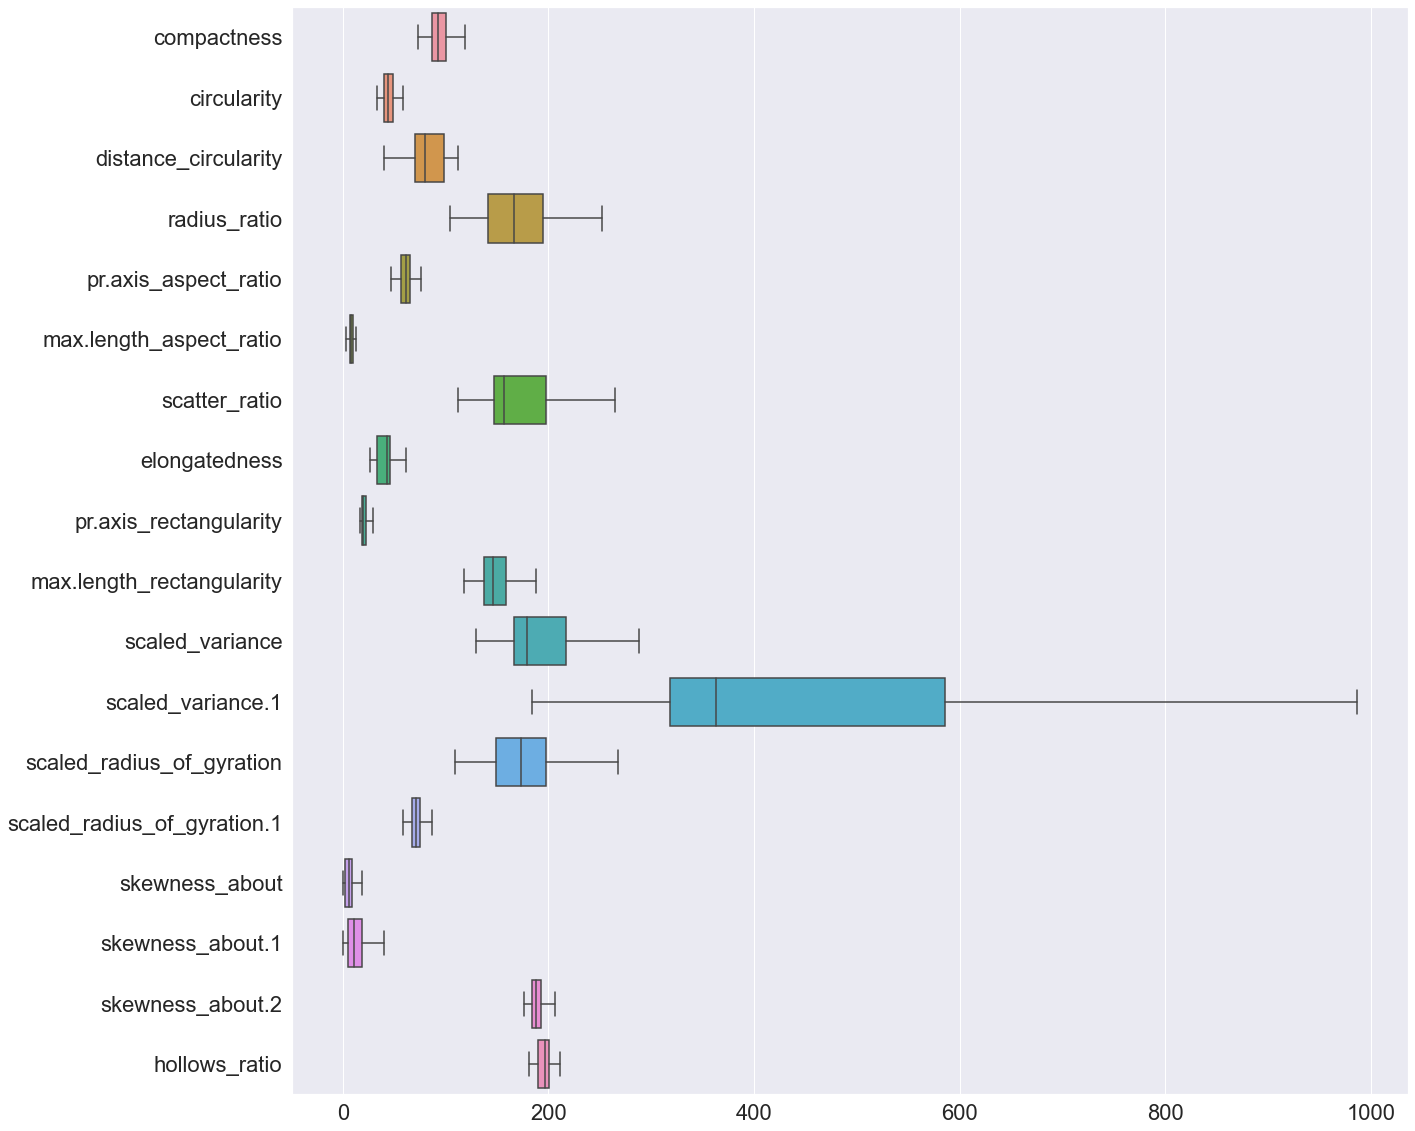

In [19]:
sns.set(font_scale=2)
plt.figure(figsize=(20,20))
sns.boxplot(data = df,orient="h")
plt.show()

## Understanding Attributes

In [20]:
le=LabelEncoder()  # Label Encoding the 'class' variable.
df['class']=le.fit_transform(df['class'])
df['class']

0      2
1      2
2      1
3      2
4      0
      ..
841    1
842    2
843    1
844    1
845    2
Name: class, Length: 846, dtype: int32

#### Multivariate Analysis

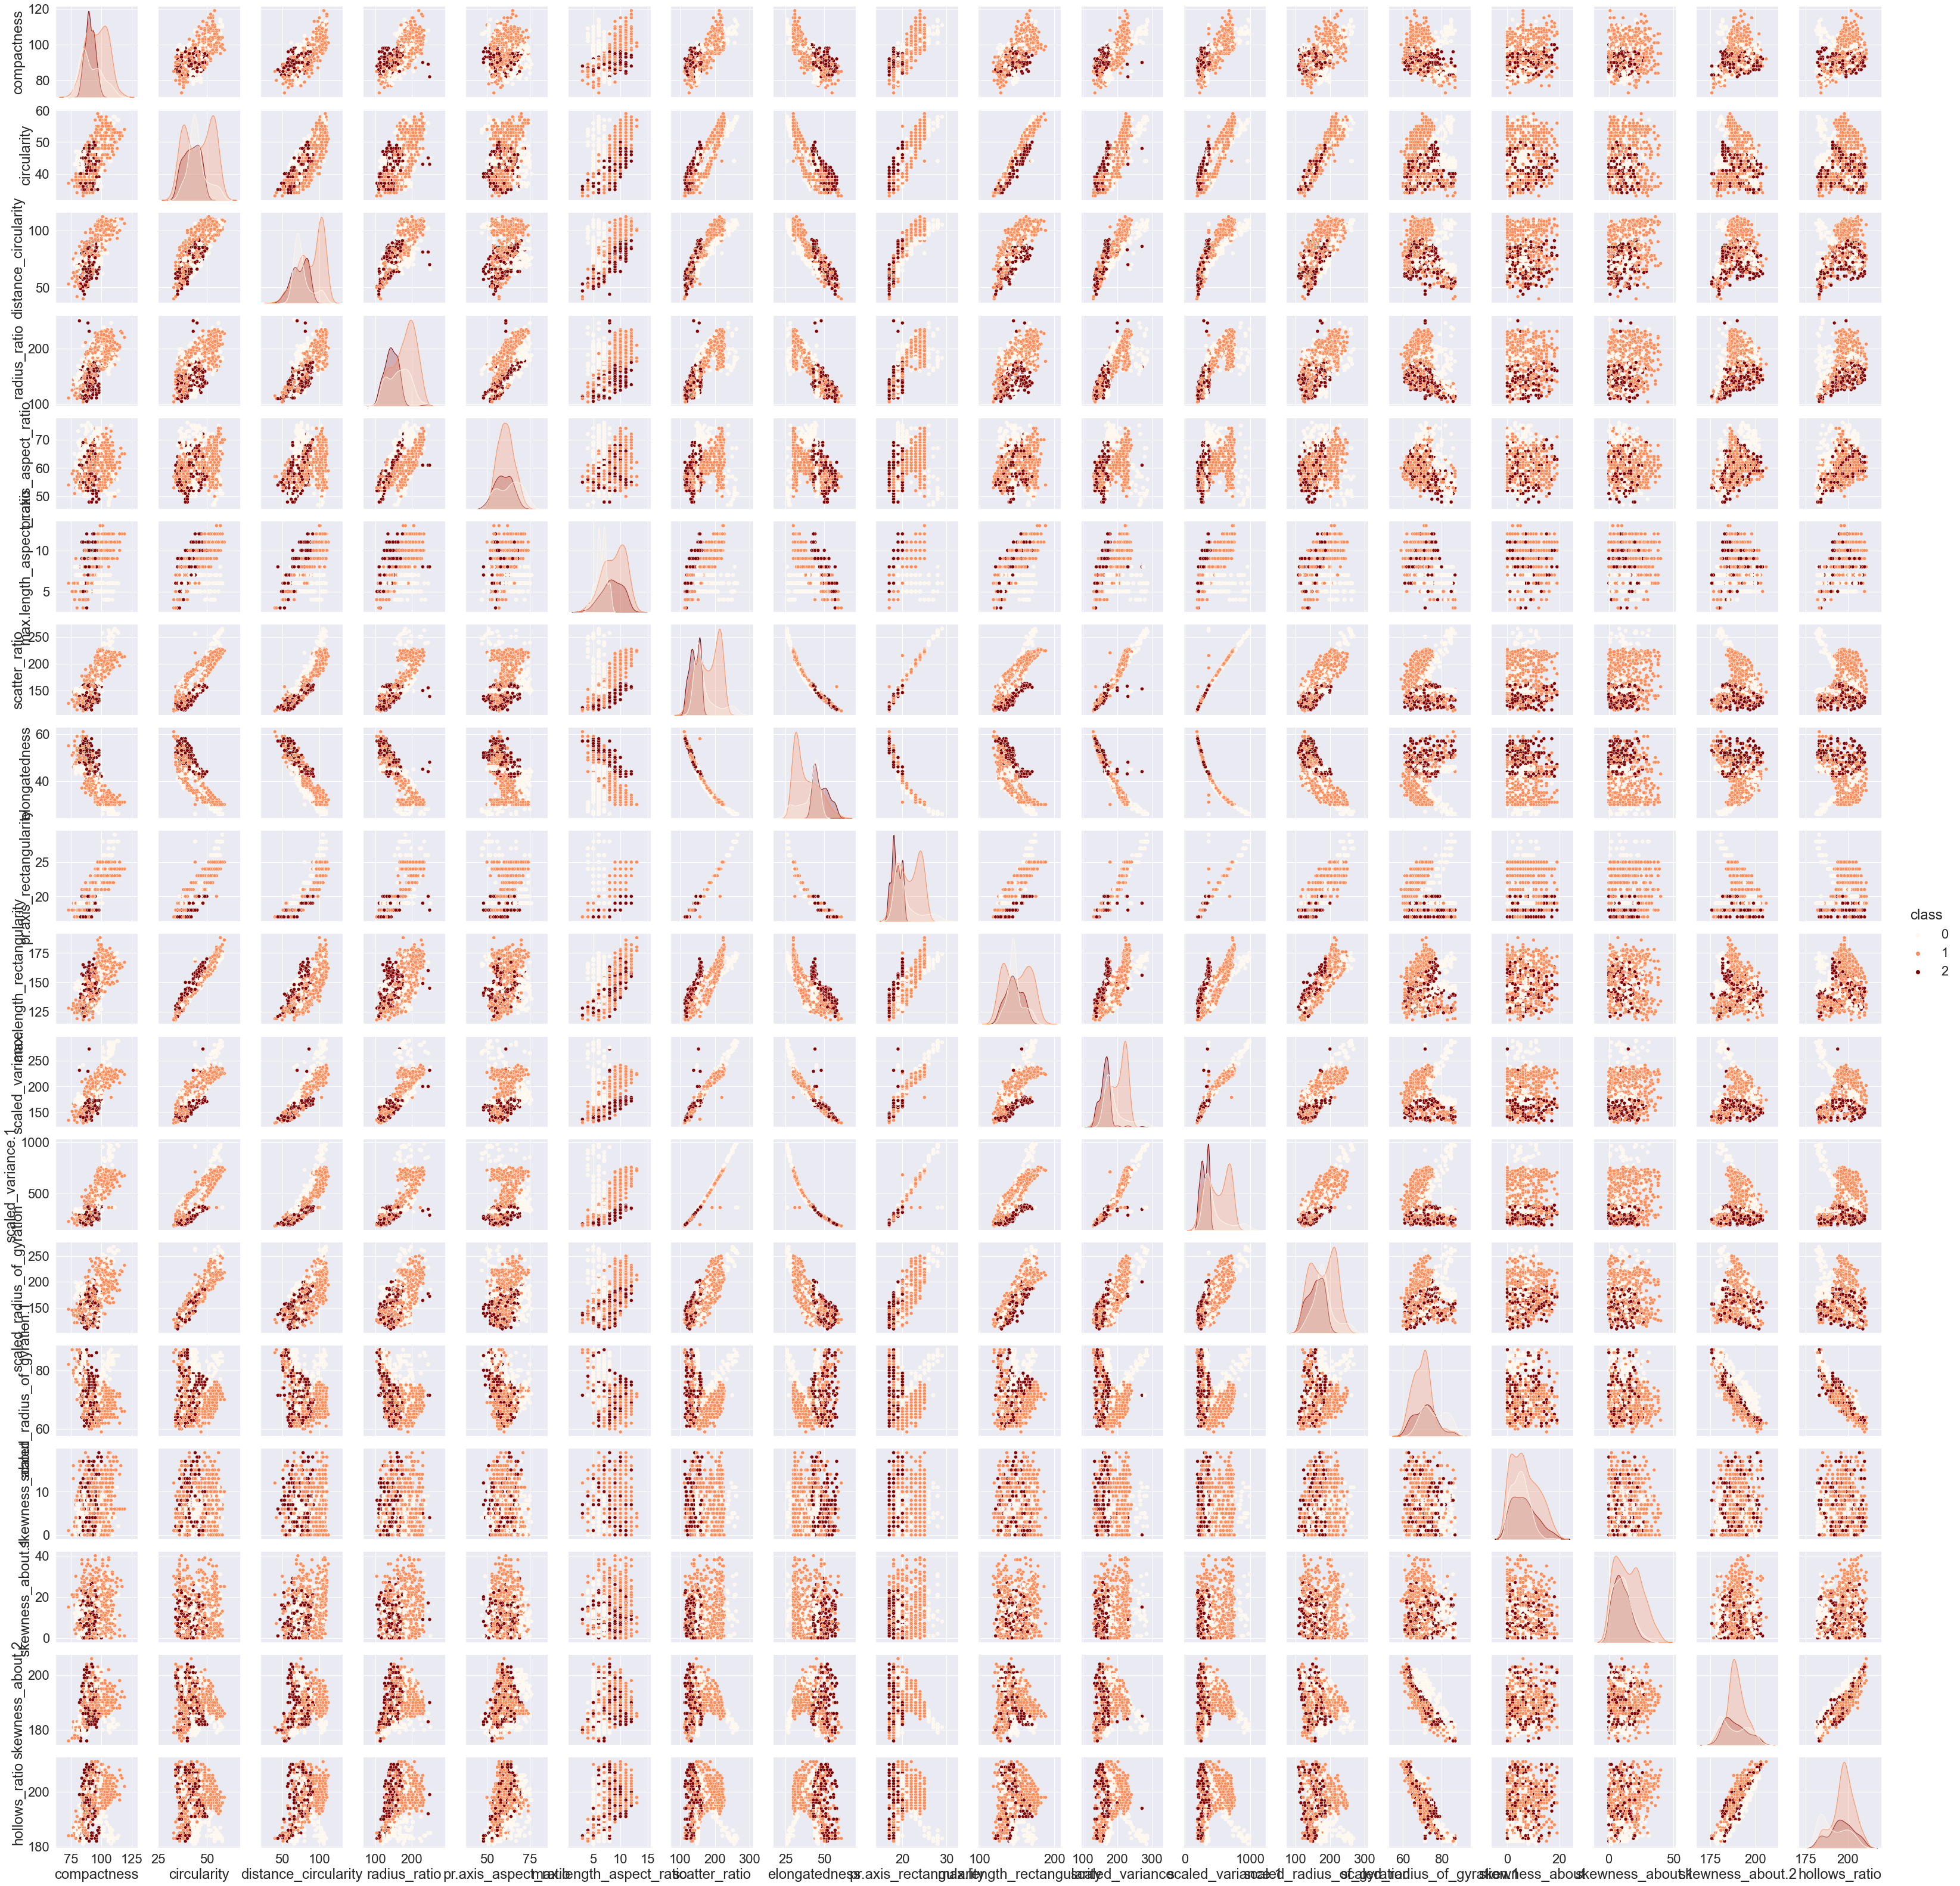

In [23]:
sns.pairplot(df, diag_kind='kde',hue='class',palette='OrRd');

In [22]:
df.corr()

compactness  circularity  distance_circularity  \
compactness                     1.000000     0.684887              0.789928   
circularity                     0.684887     1.000000              0.792320   
distance_circularity            0.789928     0.792320              1.000000   
radius_ratio                    0.721925     0.638280              0.794222   
pr.axis_aspect_ratio            0.192864     0.203253              0.244332   
max.length_aspect_ratio         0.499928     0.560470              0.666809   
scatter_ratio                   0.812620     0.847938              0.905076   
elongatedness                  -0.788750    -0.821472             -0.911307   
pr.axis_rectangularity          0.813694     0.843400              0.893025   
max.length_rectangularity       0.676143     0.961318              0.774527   
scaled_variance                 0.769871     0.802768              0.869584   
scaled_variance.1               0.806170     0.827462              0.883943   
scaled_radius_of_gyration       0.585243     0.925816              0.705771   
scaled_radius_of_gyration.1    -0.246681     0.068745             -0.229353   
skewness_about                  0.197308     0.136351              0.099107   
skewness_about.1                0.156348    -0.009666              0.262345   
skewness_about.2                0.298537    -0.104426              0.146098   
hollows_ratio                   0.365552     0.046351              0.332732   
class                          -0.033796    -0.158910             -0.064467   

                             radius_ratio  pr.axis_aspect_ratio  \
compactness                      0.721925              0.192864   
circularity                      0.638280              0.203253   
distance_circularity             0.794222              0.244332   
radius_ratio                     1.000000              0.650554   
pr.axis_aspect_ratio             0.650554              1.000000   
max.length_aspect_ratio          0.463958              0.150295   
scatter_ratio                    0.769941              0.194195   
elongatedness                   -0.825392             -0.298144   
pr.axis_rectangularity           0.744139              0.163047   
max.length_rectangularity        0.579468              0.147592   
scaled_variance                  0.786183              0.207101   
scaled_variance.1                0.760257              0.196401   
scaled_radius_of_gyration        0.550774              0.148591   
scaled_radius_of_gyration.1     -0.390459             -0.321070   
skewness_about                   0.035755             -0.056030   
skewness_about.1                 0.179601             -0.021088   
skewness_about.2                 0.405849              0.400882   
hollows_ratio                    0.491758              0.415734   
class                           -0.213948             -0.209298   

                             max.length_aspect_ratio  scatter_ratio  \
compactness                                 0.499928       0.812620   
circularity                                 0.560470       0.847938   
distance_circularity                        0.666809       0.905076   
radius_ratio                                0.463958       0.769941   
pr.axis_aspect_ratio                        0.150295       0.194195   
max.length_aspect_ratio                     1.000000       0.490759   
scatter_ratio                               0.490759       1.000000   
elongatedness                              -0.504181      -0.971601   
pr.axis_rectangularity                      0.487931       0.989751   
max.length_rectangularity                   0.642713       0.809083   
scaled_variance                             0.401391       0.960883   
scaled_variance.1                           0.463249       0.980447   
scaled_radius_of_gyration                   0.397397       0.799875   
scaled_radius_of_gyration.1                -0.335444       0.011314   
skewness_about                            

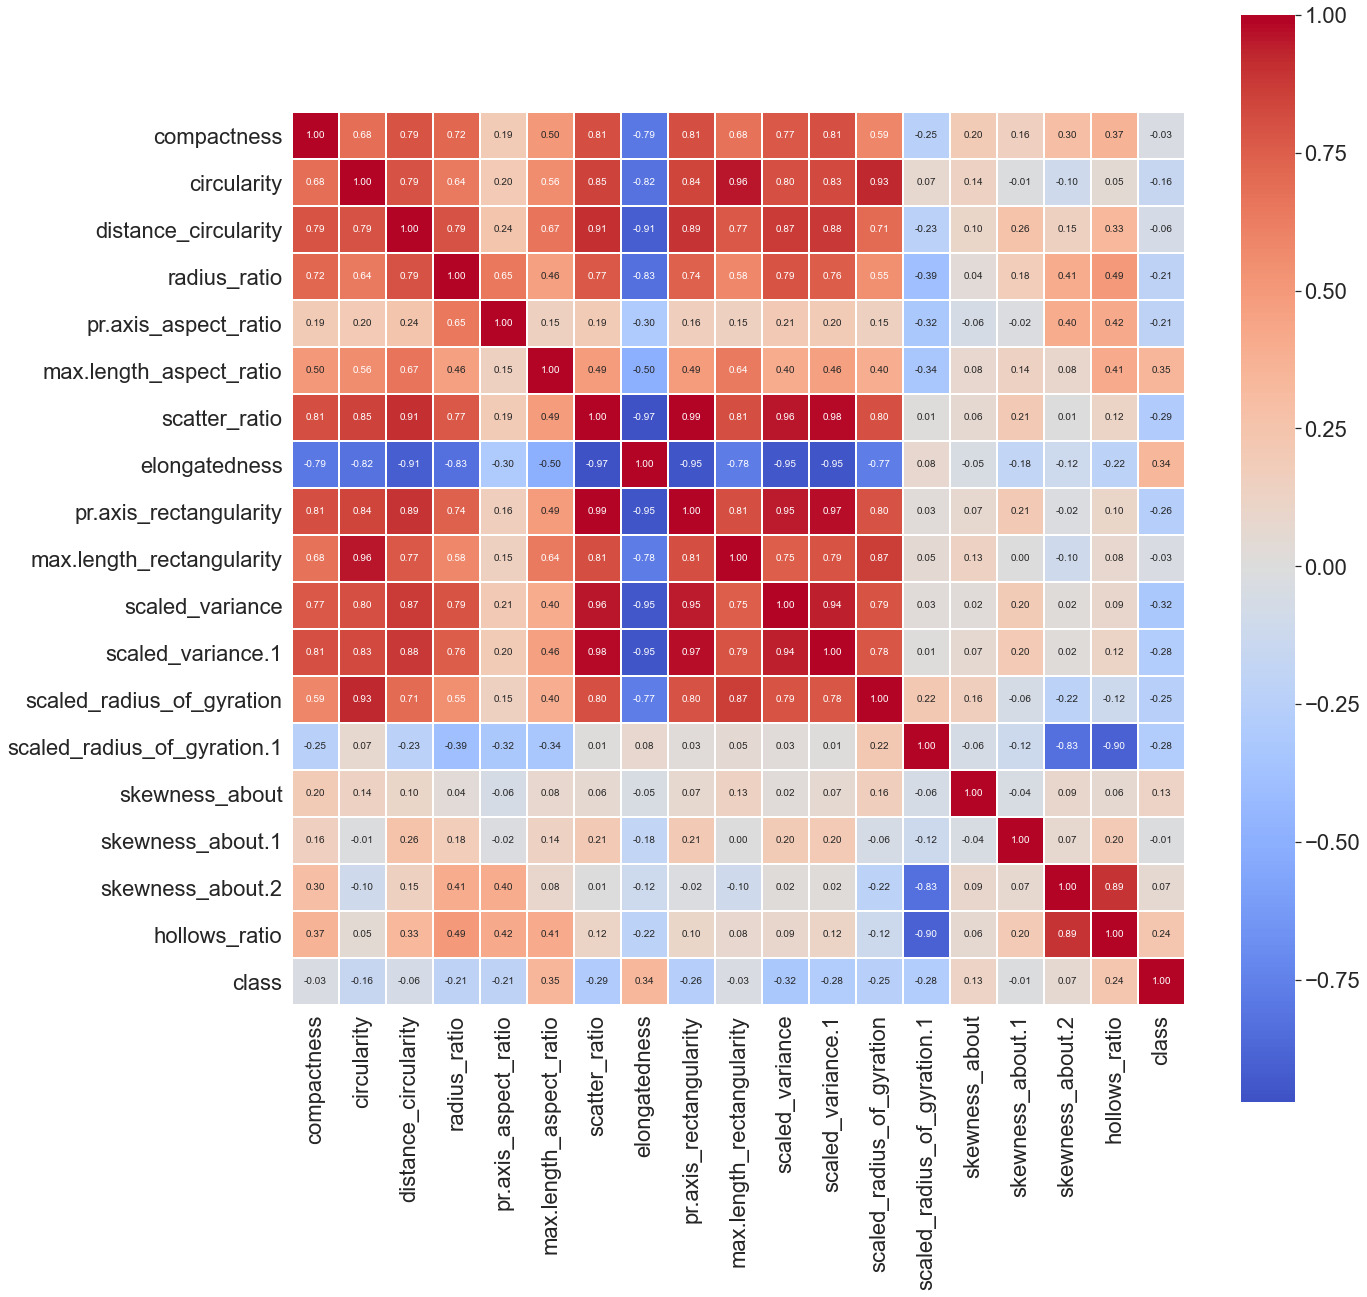

In [201]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.2f', center = 0,cmap="coolwarm",square=True)  
plt.show()

#### The idea at this stage is to identify those features which seem to have high positive or negative correlation with other features and can thus be assessed as redundant.  Such an assessment can then be compared with dimensionality reducing techniques such as PCA for accuracy.  Here, those features are being considered highly correlated when correlation values between the features is greater than 0.90.     

#### Strong Positive Correlation:-   

circularity and max.length_rectangularity   
circularity and scaled_radius_of_gyration   
distance_circularity and scatter_ratio   
scaled_variance and scatter_ratio     
scaled_variance.1 and scatter_ratio    
pr.axis_rectangularity and scatter_ratio    
pr.axis_rectangularity and scaled_variance    
pr.axis_rectangularity and scaled_variance.1    
scaled_variance and scaled_variance.1     

#### Strong Negative Correlation:-

hollows_ratio and scaled_radius_of_gyration.1    
elongatedness and distance_circularity    
elongatedness and scatter_ratio    
elongatedness and pr.axis_rectangularity    
elongatedness and scaled_variance     
elongatedness and scaled_variance.1      


#### Features that could be considered redundant:-   

max.length_rectangularity     
scaled_radius_of_gyration                                   
scatter_ratio                                      
scaled_variance                                
scaled_variance.1                               
scaled_radius_of_gyration.1      
elongatedness     

#### These seven features could probably be dropped without affecting model accuracy significantly.

#### skewness_about.2 and hollows_ratio have a strong positive correlation of 0.89.  Hence, as an exception to the rule stated above (correlation of 0.90 and above), skewness_about.2 could also be included in the list of features recommended to be dropped, taking the total number of features that could be dropped due to redundancy to eight features. These conclusions are validated by the pair plot representations as well.

## Support Vector Classifier - Without Dimensionality Reduction

In [25]:
from sklearn.model_selection import train_test_split

X=df.iloc[:,0:18].values
y = df.iloc[:,18].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# 1 - random seed number

In [105]:
print("{0:0.2f}% Data in training set".format((len(X_train)/len(df.index)) * 100)) # Check the data split.
print("{0:0.2f}% Data in test set".format((len(X_test)/len(df.index)) * 100))

69.98% Data in training set
30.02% Data in test set


In [26]:
# SVC is sensitive to scaling. Scaling training data set and test data using MinMaxScaler to preserve data shape. Dataset is not normally distributed.
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [118]:
X_train_scaled

array([[0.48837209, 0.5       , 0.84722222, ..., 0.8       , 0.53571429,
        0.63333333],
       [0.44186047, 0.57692308, 0.88888889, ..., 0.225     , 0.35714286,
        0.4       ],
       [0.09302326, 0.15384615, 0.23611111, ..., 0.125     , 0.07142857,
        0.1       ],
       ...,
       [0.37209302, 0.23076923, 0.70833333, ..., 0.575     , 0.57142857,
        0.63333333],
       [0.3255814 , 0.57692308, 0.52777778, ..., 0.35      , 0.21428571,
        0.36666667],
       [0.3255814 , 0.57692308, 0.63888889, ..., 0.375     , 0.32142857,
        0.43333333]])

In [108]:
model = SVC() # SVC on Unscaled Data
model.fit(X_train, y_train)
train_model_pred = model.predict(X_train)
print("Training Accuracy: {0:.5f}".format(metrics.accuracy_score(y_train, train_model_pred)))
test_model_pred = model.predict(X_test)
print("Test Accuracy: {0:.5f}".format(metrics.accuracy_score(y_test, test_model_pred, normalize=True)))
print("Recall: ",metrics.recall_score(y_test, test_model_pred, average='micro'))
print("Precision: ",metrics.precision_score(y_test, test_model_pred, average='micro'))
print("Classification Report")
print(metrics.classification_report(y_test, test_model_pred, labels=[2, 1, 0]))

Training Accuracy: 0.68074
Test Accuracy: 0.64961
Recall:  0.6496062992125984
Precision:  0.6496062992125984
Classification Report
              precision    recall  f1-score   support

           2       0.59      0.53      0.56        62
           1       0.80      0.74      0.77       133
           0       0.45      0.56      0.50        59

    accuracy                           0.65       254
   macro avg       0.61      0.61      0.61       254
weighted avg       0.67      0.65      0.66       254



In [109]:
model = SVC() # SVC on Scaled Data
model.fit(X_train_scaled, y_train)
train_model_pred = model.predict(X_train_scaled)
print("Training Accuracy: {0:.5f}".format(metrics.accuracy_score(y_train, train_model_pred)))
test_model_pred = model.predict(X_test_scaled)
print("Test Accuracy: {0:.5f}".format(metrics.accuracy_score(y_test, test_model_pred, normalize=True)))
print("Recall: ",metrics.recall_score(y_test, test_model_pred, average='micro'))
print("Precision: ",metrics.precision_score(y_test, test_model_pred, average='micro'))
print("Classification Report")
print(metrics.classification_report(y_test, test_model_pred, labels=[2, 1, 0]))

Training Accuracy: 0.96622
Test Accuracy: 0.94094
Recall:  0.9409448818897638
Precision:  0.9409448818897638
Classification Report
              precision    recall  f1-score   support

           2       0.95      0.94      0.94        62
           1       0.92      0.97      0.95       133
           0       0.98      0.88      0.93        59

    accuracy                           0.94       254
   macro avg       0.95      0.93      0.94       254
weighted avg       0.94      0.94      0.94       254



In [110]:
from sklearn.model_selection import RepeatedStratifiedKFold   # Using stratified k-fold cross validation with repetition.
from sklearn.model_selection import cross_val_score
fold=RepeatedStratifiedKFold(n_splits=10,random_state=1)
result=cross_val_score(model,X,y,cv=fold,scoring='accuracy',n_jobs=-1)
score="%f (%f)"%(result.mean()*100,result.std()*100)
print(score) 

68.061204 (5.473976)


In [111]:
from sklearn.model_selection import RepeatedStratifiedKFold   # Using stratified k-fold cross validation with repetition on scaled data.
from sklearn.model_selection import cross_val_score
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
fold=RepeatedStratifiedKFold(n_splits=10,random_state=1)
result=cross_val_score(model,X_scaled,y,cv=fold,scoring='accuracy',n_jobs=-1)
score="%f (%f)"%(result.mean()*100,result.std()*100)
print(score) 

95.600140 (2.411869)


In [112]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
			'kernel': ['rbf','poly','linear']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0, n_jobs=-1) 
grid.fit(X_train_scaled, y_train) 
print(grid.best_params_) 
print(grid.best_estimator_) 
grid_predictions = grid.predict(X_test_scaled) 
print(classification_report(y_test, grid_predictions)) 

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        59
           1       0.93      0.99      0.96       133
           2       0.98      0.90      0.94        62

    accuracy                           0.96       254
   macro avg       0.97      0.94      0.96       254
weighted avg       0.96      0.96      0.96       254



In [175]:
from sklearn.model_selection import RepeatedStratifiedKFold   # Using stratified k-fold cross validation with repetition on scaled data.
from sklearn.model_selection import cross_val_score
model = SVC(C=10,gamma=1,kernel='rbf')
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
fold=RepeatedStratifiedKFold(n_splits=10,random_state=1)
result=cross_val_score(model,X_scaled,y,cv=fold,scoring='accuracy',n_jobs=-1)
score="%f (%f)"%(result.mean()*100,result.std()*100)
print(score) 

97.184734 (1.909720)


Text(0.5, 11.5, 'Predicted')

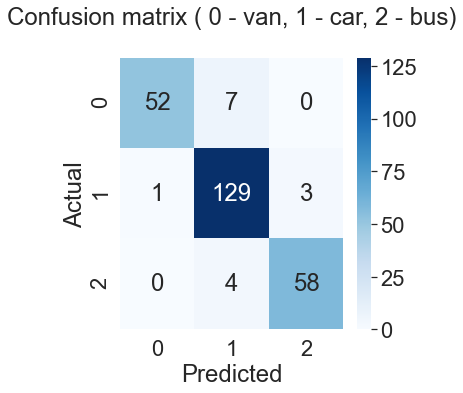

In [113]:
conf_mat = confusion_matrix(y_test, test_model_pred)
SVC_conf_mat = pd.DataFrame(conf_mat)
plt.figure(figsize = (5,5))
sns.heatmap(SVC_conf_mat, annot=True,cmap='Blues', fmt='g')
plt.title('Confusion matrix ( 0 - van, 1 - car, 2 - bus)', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Inference - 

#### The impact of scaling on SVC is astounding in this case.   With unscaled data, model accuracy was 68% with SD of 5.5%.  With scaled data, hyperparameter tuning and cross validation however, model accuracy improved to 97% with SD of 2%.  Thus with 95% certainty, the SVC model on scaled data would likely generate model accuracies between 93% and 100%.

## Applying Dimensionality Reduction using PCA

In [27]:
from sklearn.model_selection import train_test_split

X=df.iloc[:,0:18].values
y = df.iloc[:,18].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# 1 - random seed number

In [28]:
print("{0:0.2f}% Data in training set".format((len(X_train)/len(df.index)) * 100)) # Check the data split.
print("{0:0.2f}% Data in test set".format((len(X_test)/len(df.index)) * 100))

69.98% Data in training set
30.02% Data in test set


In [29]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
# Generating the covariance matrix for PCA analysis
cov_matrix = np.cov(X_scaled.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 0.03204469  0.0289259   0.03091585  0.02807123  0.00668286  0.01847222
   0.03156331 -0.0315141   0.03142068  0.02509893  0.02706946  0.03133295
   0.02144461 -0.00971303  0.00850093  0.00621153  0.01095945  0.01622589]
 [ 0.0289259   0.05566464  0.04087011  0.03271086  0.00928236  0.02729455
   0.04340805 -0.04325835  0.04292397  0.0470322   0.0372018   0.04238718
   0.04471143  0.00356758  0.00774265 -0.00050616 -0.00505258  0.00271162]
 [ 0.03091585  0.04087011  0.04780035  0.03771799  0.0103402   0.03009197
   0.04293556 -0.04447007  0.04211685  0.03511484  0.03734317  0.04196009
   0.03158521 -0.01102965  0.00521509  0.01272969  0.00655048  0.01803816]
 [ 0.02807123  0.03271086  0.03771799  0.04718261  0.02735312  0.02080194
   0.03628817 -0.04001648  0.03486759  0.02610111  0.03354276  0.03585488
   0.02448885 -0.01865555  0.00186926  0.0086582   0.01807875  0.02648647]
 [ 0.00668286  0.00928236  0.0103402   0.02735312  0.03746838  0.00600496
   0.0081561

In [31]:
# Generating the eigen values and the eigen vectors
e_vals, e_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s' %e_vecs)
print('\n Eigen Values \n%s' %e_vals)

Eigen Vectors 
[[ 2.27437296e-01 -6.83530681e-02 -6.65784941e-02 -7.24281778e-02
  -4.99188943e-02  2.51272423e-01 -9.38068593e-02  6.70703113e-01
   5.33244464e-01  2.64599509e-01 -1.00575049e-01 -3.19851203e-02
  -2.26412049e-02  8.22387094e-02 -1.32650753e-01  5.22392674e-02
   1.28080597e-01  1.19540359e-02]
 [ 3.18518978e-01  1.41784784e-01 -1.44417244e-01  1.48441760e-01
   1.67107244e-01 -1.13102942e-01  4.31580496e-01  6.25278881e-03
   8.74161385e-02 -1.56799099e-01 -9.20523383e-03  1.89557477e-01
  -4.45047132e-02  4.68256467e-02 -2.34852274e-01 -5.71350045e-01
   7.72325093e-02 -3.85427766e-01]
 [ 3.10822649e-01 -4.63555059e-02  3.26936303e-02 -1.02713200e-01
   9.99668400e-02  1.08018269e-02 -2.13507292e-01 -2.88049106e-01
  -2.10833260e-02  4.30722185e-01 -4.99478592e-01  5.13000956e-01
   4.54392909e-03 -1.50393651e-01  1.43589680e-01  1.11965185e-02
  -6.63113684e-02 -6.75238249e-02]
 [ 2.75153776e-01 -1.84957029e-01  9.58068199e-02  1.54502658e-01
  -2.62041230e-01 -1.8

In [32]:
# Make a set of (eigenvalue, eigenvector) pairs
eigen_pairs = [(np.abs(e_vals[i]), e_vecs[:,i]) for i in range(len(e_vals))]
eigen_pairs.sort(reverse=True)
eigen_pairs[:]

[(0.4420078975378031,
  array([ 0.2274373 ,  0.31851898,  0.31082265,  0.27515378,  0.08925639,
          0.18999353,  0.31593811, -0.32379892,  0.31071362,  0.2709842 ,
          0.27577336,  0.31101183,  0.25282315, -0.04498737,  0.04127874,
          0.0620233 ,  0.03748126,  0.10058318])),
 (0.16388120048239066,
  array([-0.06835307,  0.14178478, -0.04635551, -0.18495703, -0.20930144,
         -0.10726004,  0.0760872 , -0.01707486,  0.08704833,  0.11354715,
          0.07183491,  0.07270593,  0.19643254,  0.50439941, -0.02005029,
         -0.09964036, -0.46320261, -0.57329418])),
 (0.0629896106710779,
  array([-0.06657849, -0.14441724,  0.03269363,  0.09580682,  0.079087  ,
         -0.10227551,  0.07850322, -0.0876014 ,  0.06890688, -0.13988543,
          0.10836311,  0.07847349, -0.1371463 ,  0.06192366, -0.8432333 ,
          0.39190295, -0.05315514, -0.03993956])),
 (0.052726540493394494,
  array([-0.07242818,  0.14844176, -0.1027132 ,  0.15450266,  0.40194703,
         -0.0607

Cumulative Variance Explained [ 52.87672973  72.48158746  80.01693839  86.3245339   91.17435557
  94.50996549  96.25913788  97.28748332  97.98459196  98.40911967
  98.79617888  99.14957593  99.39137032  99.57550767  99.73183009
  99.85731457  99.97091936 100.        ]


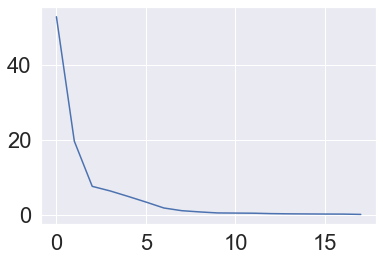

In [33]:
# The "Cumulative Variance Explained" analysis 
tot = sum(e_vals)
var_exp = [( i /tot ) * 100 for i in sorted(e_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)
plt.plot(var_exp);

#### There is a drop in variance as the number of Principal Components increases.  The mandate of the project is to extract Principal Components that capture about 95% of the variance in the data.  The top seven components are enough to achieve that target.  The top 10 principal components capture 98.5% of variance in the data. 

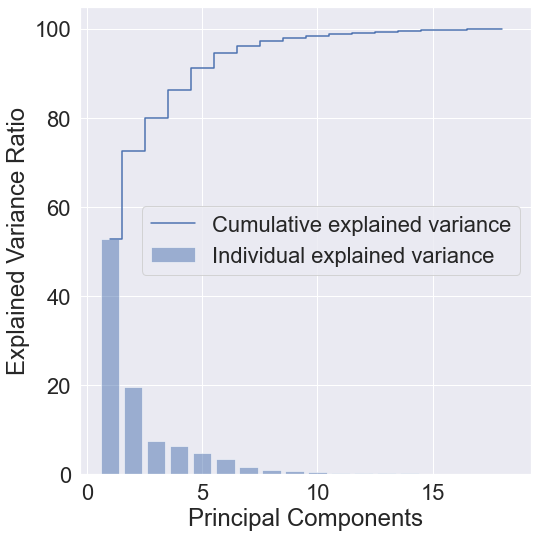

In [34]:
# Plotting the variance explained by the principal components and the cumulative variance explained.
plt.figure(figsize=(8 , 8))
plt.bar(range(1, e_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, e_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

#### Let us proceed with the top 10 Principal Components, eliminating the last eight Principal Components.   This number now matches the one proposed in the EDA phase of this project.  It is noteworthy that by using PCA, this conclusion has been reached far more easily and more objectively as well.  

In [35]:
P_reduce = np.array(e_vecs[0:10])   
X_std_10D = np.dot(X_scaled,P_reduce.T)   
# converting array to dataframe for pairplot
df_PCA = pd.DataFrame(X_std_10D)  

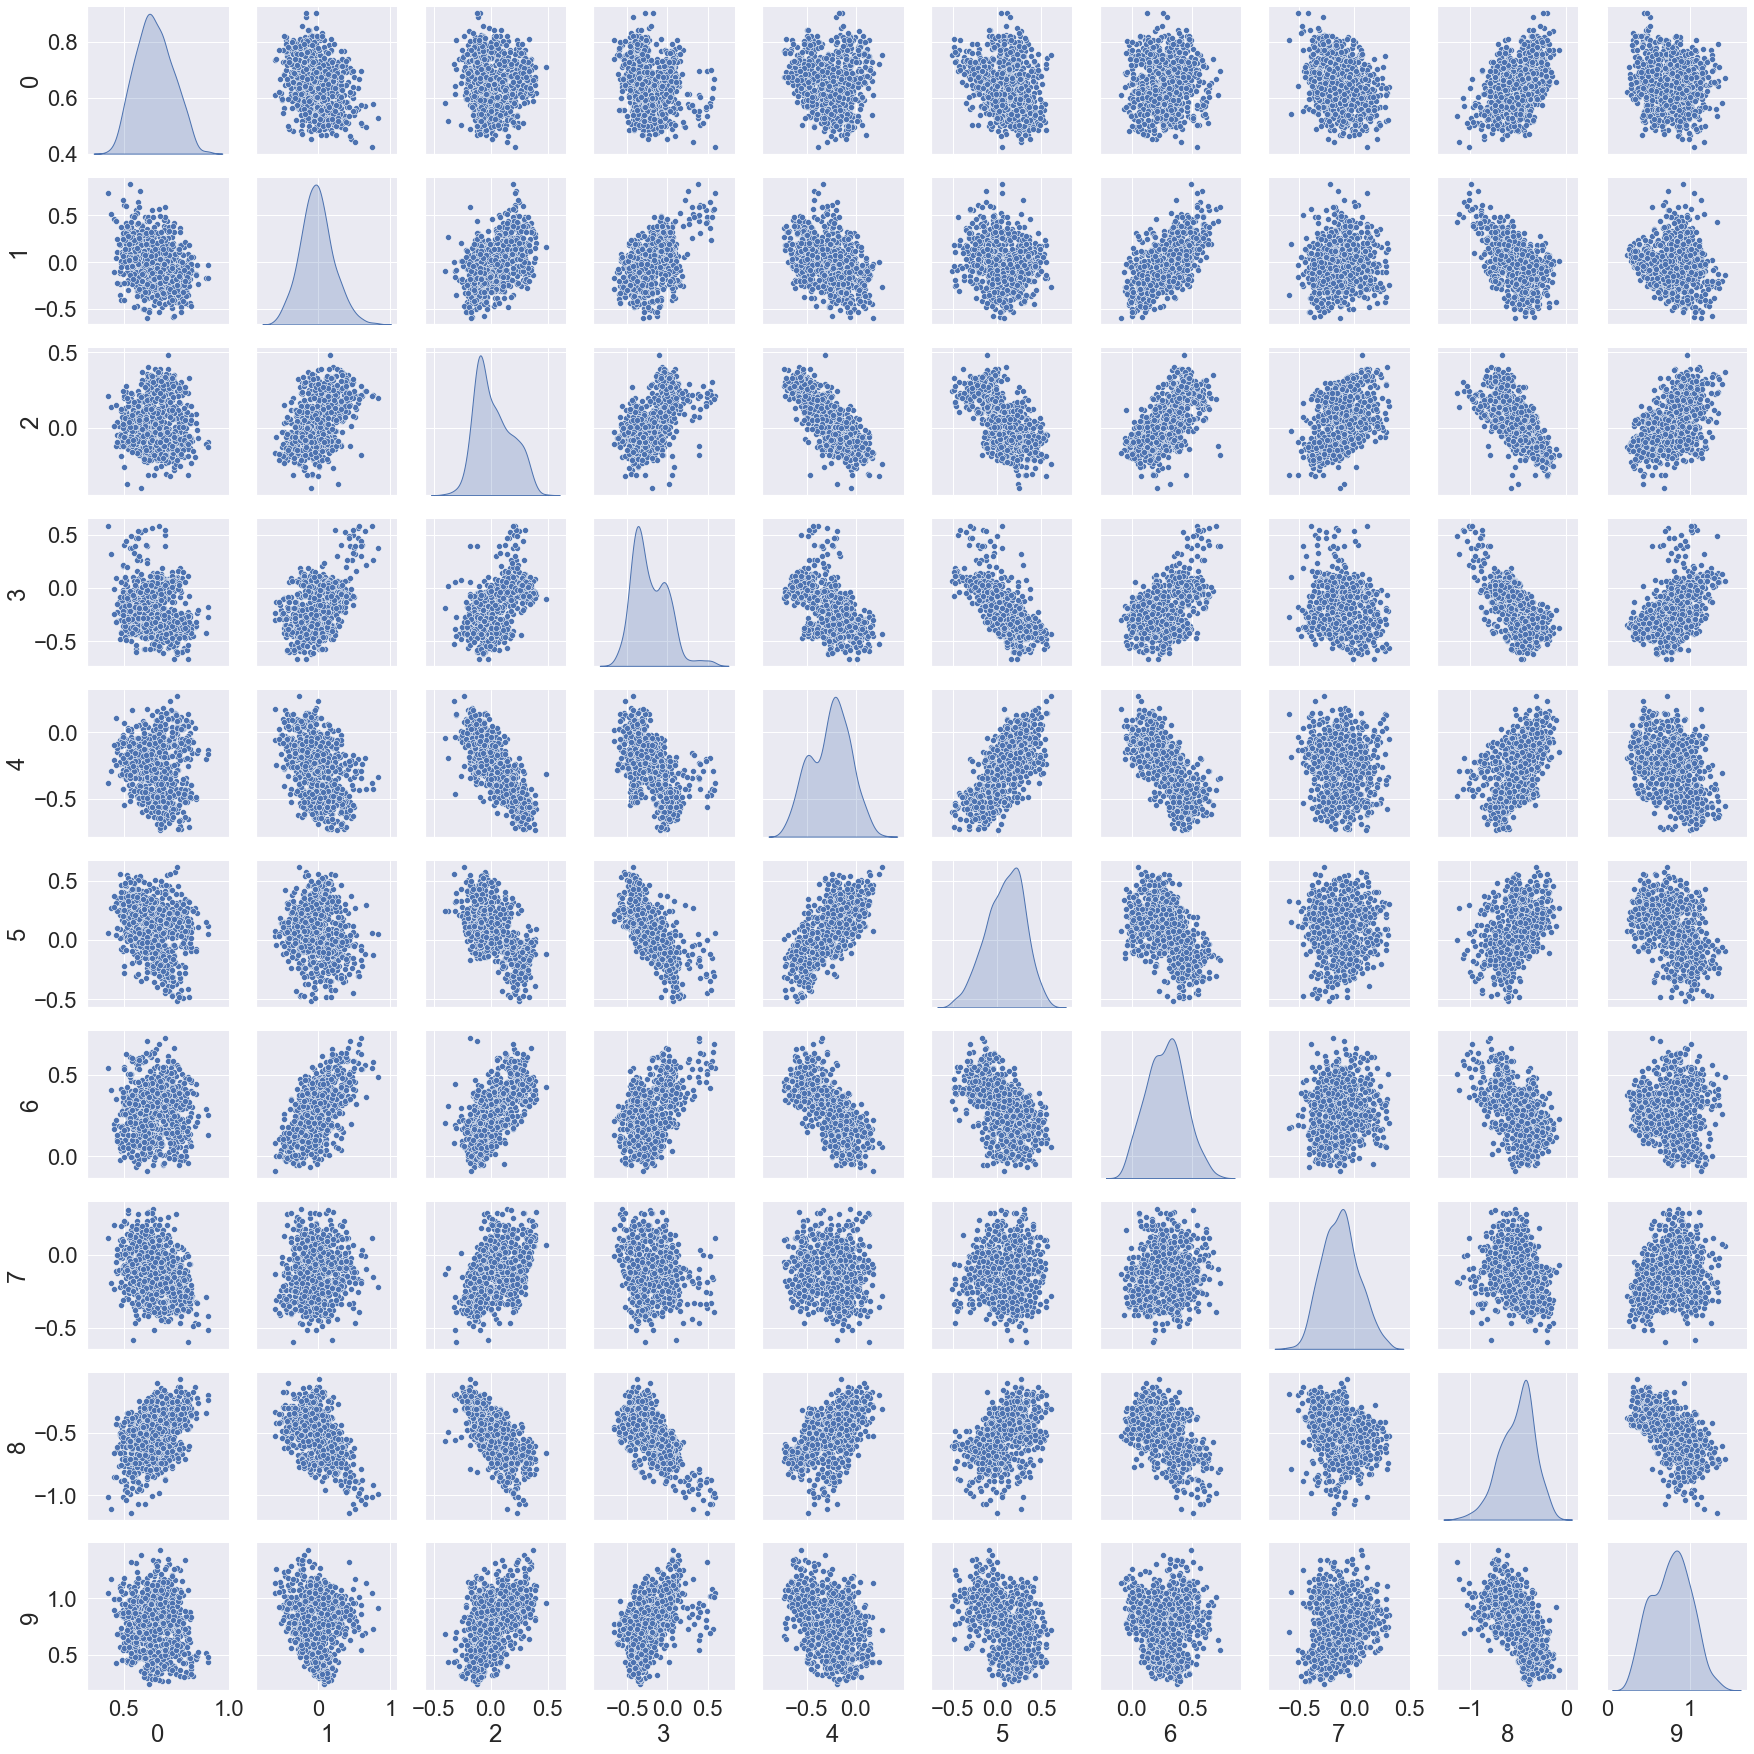

In [37]:
sns.pairplot(df_PCA, diag_kind='kde');

#### Now, there is almost no correlation between independent variables.

In [169]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_PCA, y, test_size=0.3, random_state=1)
# 1 - random seed number

In [170]:
model = SVC() # SVC on Scaled Data
model.fit(X_train, y_train)
train_model_pred = model.predict(X_train)
print("Training Accuracy: {0:.5f}".format(metrics.accuracy_score(y_train, train_model_pred)))
test_model_pred = model.predict(X_test)
print("Test Accuracy: {0:.5f}".format(metrics.accuracy_score(y_test, test_model_pred, normalize=True)))
print("Recall: ",metrics.recall_score(y_test, test_model_pred, average='macro'))
print("Precision: ",metrics.precision_score(y_test, test_model_pred, average='macro'))
print("Classification Report")
print(metrics.classification_report(y_test, test_model_pred, labels=[2, 1, 0]))

Training Accuracy: 0.93412
Test Accuracy: 0.94094
Recall:  0.9386252673783968
Precision:  0.9361533005600803
Classification Report
              precision    recall  f1-score   support

           2       0.90      0.92      0.91        62
           1       0.95      0.95      0.95       133
           0       0.95      0.95      0.95        59

    accuracy                           0.94       254
   macro avg       0.94      0.94      0.94       254
weighted avg       0.94      0.94      0.94       254



In [171]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
			'kernel': ['rbf','poly','linear']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0, n_jobs=-1) 
grid.fit(X_train, y_train) 
print(grid.best_params_) 
print(grid.best_estimator_) 
grid_predictions = grid.predict(X_test) 
print(classification_report(y_test, grid_predictions)) 

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=100, gamma=1)
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        59
           1       0.96      0.96      0.96       133
           2       0.96      0.87      0.92        62

    accuracy                           0.95       254
   macro avg       0.95      0.94      0.94       254
weighted avg       0.95      0.95      0.95       254



In [174]:
from sklearn.model_selection import RepeatedStratifiedKFold   # Using stratified k-fold cross validation with repetition on scaled data.
from sklearn.model_selection import cross_val_score
model = SVC(C=100, gamma=1, kernel='rbf')
fold=RepeatedStratifiedKFold(n_splits=10,random_state=1)
result=cross_val_score(model,df_PCA,y,cv=fold,scoring='accuracy',n_jobs=-1)
score="%f (%f)"%(result.mean()*100,result.std()*100)
print(score) 

95.506583 (2.457567)


### Comparison - 

####  With unscaled data, using the complete dataset, model accuracy using SVC was 68% with SD of 5.5%.  With scaled data, hyperparameter tuning and cross validation however, the SVC based model accuracy improved to 97% with SD of 2%.  Thus with 95% certainty, the SVC model on scaled data would likely generate model accuracies between 93% and 100%.

#### Thereafter, the exercise was repeated with dimensionality reduction using PCA.  The number of dimensions was reduced from 18 to 10. Covered variance was 98.5%.  Now, with scaled data, hyperparameter tuning and cross validation, the PCA based SVC model had an accuracy score of 95.5% with SD of 2.5%. Thus with 95% certainty, the SVC model on scaled data would likely generate model accuracies between 90.5% and 100%.

## Conclusion -

###  The project objective of using the dimensionality reduction technique, PCA on a dataset was achieved with clearly demonstrated interpretable results.  PCA is a very effective tool to focus on independent variables, select the best among them and apply them easily with nil or little compromise on model accuracy.